In [ ]:
#importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten,LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error 
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from keras import backend
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.regularizers import l1,l2
from keras.initializers import he_normal,glorot_normal
from keras.layers import LeakyReLU

In [ ]:
#loading training data
df = pd.read_feather('/content/drive/MyDrive/ashrae_Great_Energy_Prediction/train_feature_engineering.feather')
df.drop(['index','timestamp','meter_reading'],axis=1,inplace=True)

### Splitting the data for training and validation

In [ ]:
x_train = df[df['timestamp']<='2016-09-30']
x_val = df[df['timestamp']>'2016-09-30']

In [ ]:
y_train = x_train['log_meter_reading']
x_train = x_train.drop(['timestamp','log_meter_reading','meter_reading'],axis=1)
y_val = x_val['log_meter_reading']
x_val = x_val.drop(['timestamp','log_meter_reading','meter_reading'],axis=1)

### Building Neural Network

In [ ]:
backend.clear_session()
building_id = Input(shape=(1,),name='building_id')
site_id = Input(shape=(1,),name='site_id')
meter = Input(shape=(1,),name='meter')
primary_use = Input(shape=(1,),name='primary_use')
square_feet = Input(shape=(1,),name='square_feet')
year_built = Input(shape=(1,),name='year_built')
cloud_coverage = Input(shape=(1,),name='cloud_coverage')
dew_temperature = Input(shape=(1,),name='dew_temperature')
air_temperature = Input(shape=(1,),name='air_temperature')
day = Input(shape=(1,),name='day')
precip_depth_1_hr = Input(shape=(1,),name='precip_depth_1_hr')
sea_level_pressure = Input(shape=(1,),name='sea_level_pressure')
hour = Input(shape=(1,),name='hour')
month = Input(shape=(1,),name='month')
weekday = Input(shape=(1,),name='weekday')
is_winter_month = Input(shape=(1,),name='is_winter_month')
is_summer_month = Input(shape=(1,),name='is_summer_month')
is_pub_holiday = Input(shape=(1,),name='is_pub_holiday')
is_weekday = Input(shape=(1,),name='is_weekday')
horizsolar = Input(shape=(1,),name='horizsolar')
Sensible_Heat = Input(shape=(1,),name='Sensible_Heat')
relative_humidity = Input(shape=(1,),name='relative_humidity')
discomfort_index = Input(shape=(1,),name='discomfort_index')
wind_chill = Input(shape=(1,),name='wind_chill')
wind_speed = Input(shape=(1,),name='wind_speed')
wind_direction = Input(shape=(1,),name='wind_direction')
busy_hours = Input(shape=(1,),name='busy_hours')

# Embedding Layers
building_id_embedding = Embedding(1449, 6)(building_id)
site_id_embedding = Embedding(17, 2)(site_id)
meter_embedding = Embedding(5, 2)(meter)
primary_use_embedding = Embedding(17, 2)(primary_use)
day_embedding = Embedding(367,3)(day)
month_embedding = Embedding(13,2)(month)
hour_embedding = Embedding(25,3)(hour)
weekday_embedding = Embedding(8, 2)(weekday)
#concatenation of embedding_layers
concat_embedding = concatenate([Flatten() (building_id_embedding)
                              , Flatten() (meter_embedding)
                              , Flatten() (primary_use_embedding)
                              , Flatten() (day_embedding)
                              , Flatten() (hour_embedding)
                              , Flatten() (weekday_embedding)
                              , Flatten() (site_id_embedding)
                              , Flatten() (month_embedding)])
#concat_embedding = tf.expand_dims(concat_embedding, axis=-1)

res = Dropout(0.01)(Dense(1024,activation='relu') (concat_embedding))
res = BatchNormalization()(res)
res = Dropout(0.01)(Dense(512,activation='relu') (res))
final = concatenate([res, square_feet,air_temperature,year_built,is_winter_month,is_pub_holiday,is_weekday,horizsolar])
final = tf.expand_dims(final, axis=-2)

lstm = LSTM(64, return_sequences=True)(final)
flatten = Flatten()(lstm)
final = Dropout(0.01)(Dense(64,activation='relu') (flatten))
final = BatchNormalization()(final)
final = Dropout(0.01)(Dense(16,activation='relu') (final))

#output
output = Dense(1,activation='linear') (final)

model = Model(inputs = [building_id,meter,primary_use,square_feet,year_built,day,cloud_coverage,dew_temperature,air_temperature,site_id,month,
                        hour,weekday,is_winter_month,precip_depth_1_hr,sea_level_pressure,wind_speed,wind_direction,wind_chill,Sensible_Heat,
                        is_pub_holiday,is_weekday,horizsolar,discomfort_index,busy_hours,relative_humidity,is_summer_month], outputs = output)



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
building_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
meter (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
primary_use (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
day (InputLayer)                [(None, 1)]          0                                            
______________________________________________________________________________________________

### Function for calculating rmse

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(lr=0.001),loss = root_mean_squared_error)

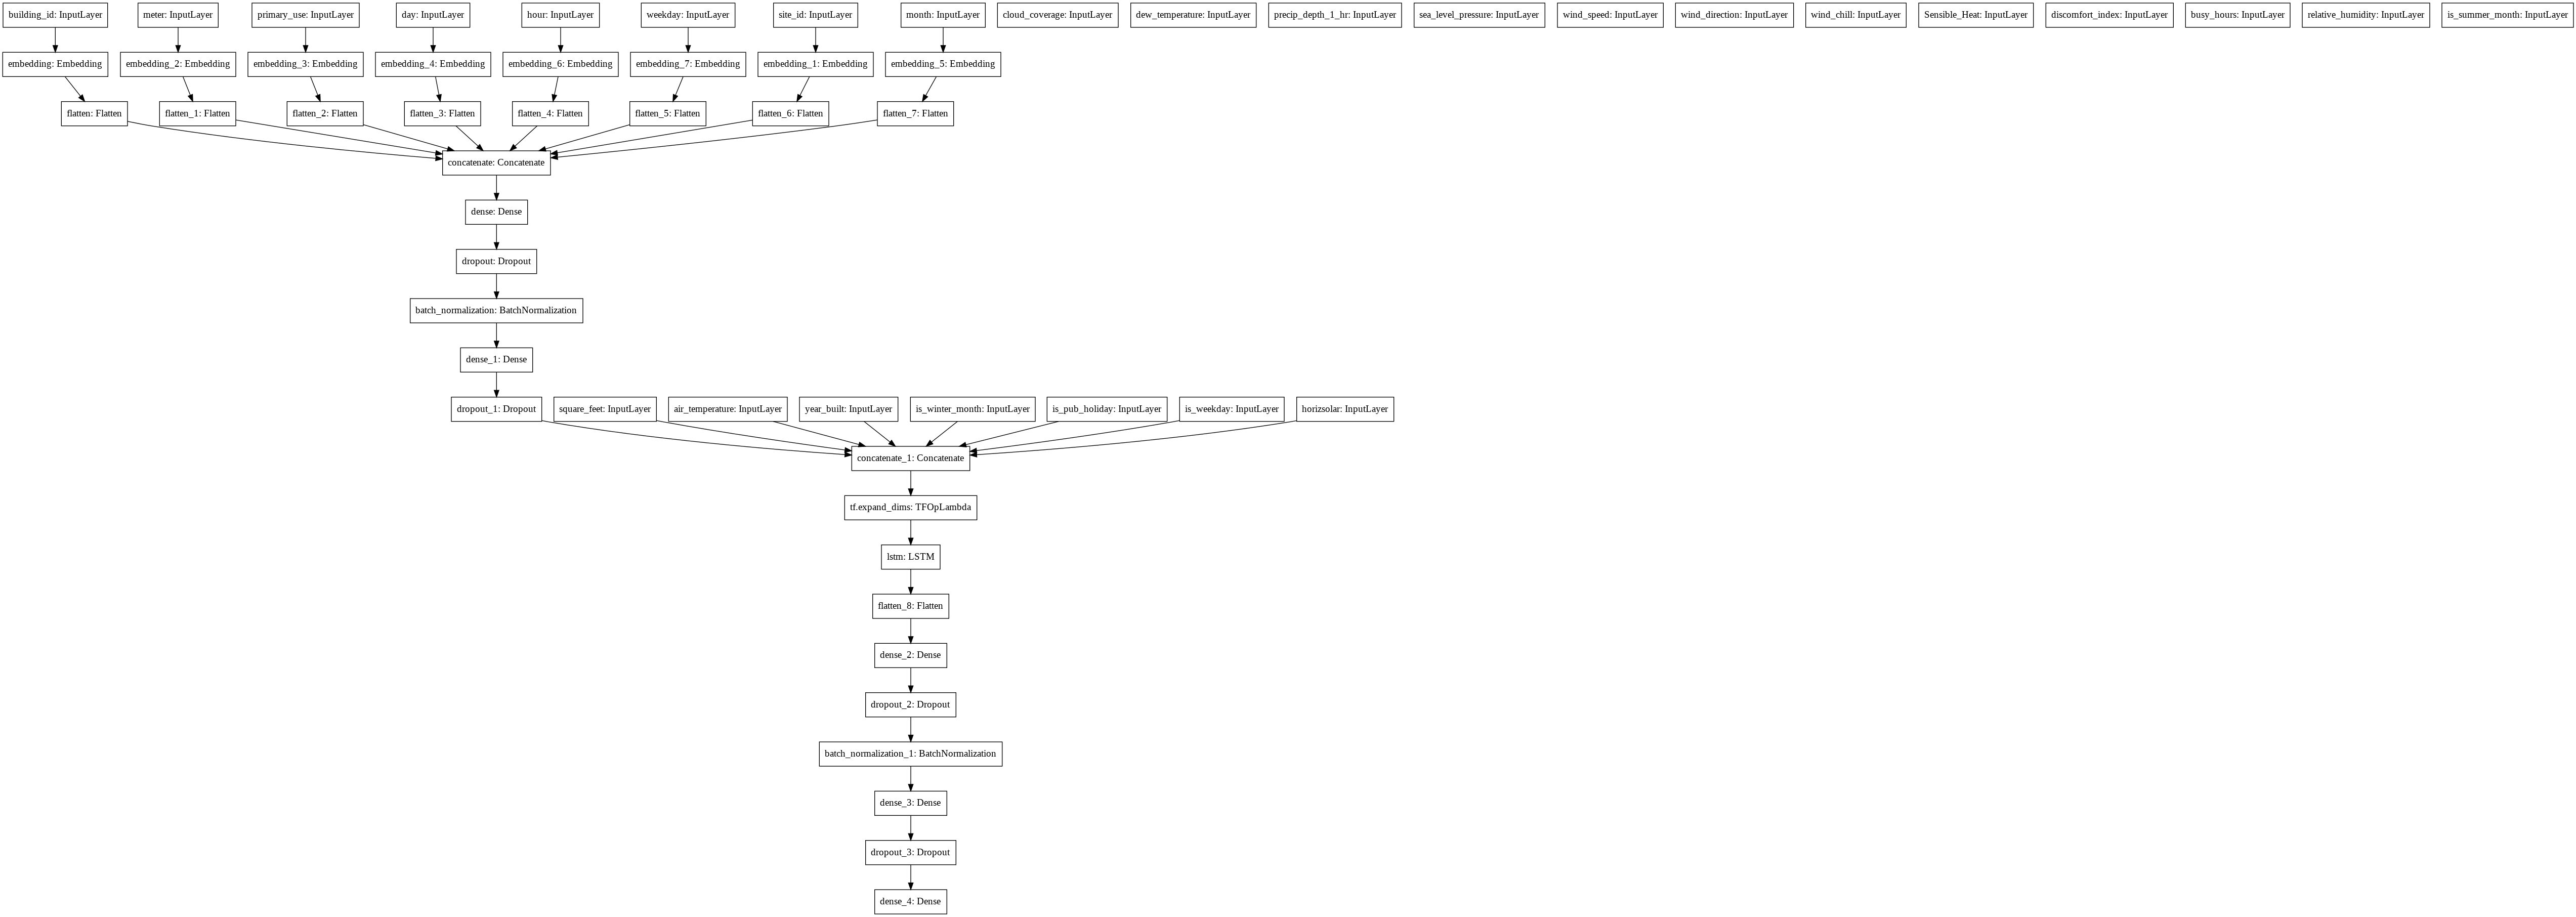

In [ ]:
plot_model(model)

In [ ]:
def get_keras_data(df,cols):
    X = {col: np.array(df[col]) for col in cols}
    return X

In [ ]:
folds = 4
seed = 666
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

In [ ]:
models = []

i = 0
for train_idx, val_idx in kf.split(df,df['site_id']):
    train_data = df.iloc[train_idx,:]
    val_data = df.iloc[val_idx,:]
    yy_train = train_data['log_meter_reading']
    xx_train = train_data.drop(['log_meter_reading'], axis=1)
    del train_data
    yy_val = val_data['log_meter_reading']
    xx_val = val_data.drop(['log_meter_reading'], axis=1)
    del val_data
    cols = xx_train.columns
    x_train = get_keras_data(xx_train,cols)
    x_val = get_keras_data(xx_val, cols)
    del xx_train,xx_val

    early_stopping = EarlyStopping(patience=3, verbose=1)
    model_checkpoint = ModelCheckpoint("model_" + str(i) + ".hdf5",
                                       save_best_only=True, verbose=1, monitor='val_loss', mode='min')

    hist = model.fit(x_train,yy_train, batch_size=1024, epochs=15,
                            validation_data=(x_val,yy_val), verbose=1,callbacks=[early_stopping, model_checkpoint])

    model1 = load_model("model_" + str(i) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
    models.append(model1)  
    i +=1

Epoch 1/15
14429/14429 [==============================] - 167s 11ms/step - loss: 1.7846 - val_loss: 1.4815

Epoch 00001: val_loss improved from inf to 1.48154, saving model to model_0.hdf5
Epoch 2/15
14429/14429 [==============================] - 158s 11ms/step - loss: 1.4677 - val_loss: 1.3439

Epoch 00002: val_loss improved from 1.48154 to 1.34387, saving model to model_0.hdf5
Epoch 3/15
14429/14429 [==============================] - 158s 11ms/step - loss: 1.3288 - val_loss: 1.2661

Epoch 00003: val_loss improved from 1.34387 to 1.26613, saving model to model_0.hdf5
Epoch 4/15
14429/14429 [==============================] - 157s 11ms/step - loss: 1.2671 - val_loss: 1.2163

Epoch 00004: val_loss improved from 1.26613 to 1.21633, saving model to model_0.hdf5
Epoch 5/15
14429/14429 [==============================] - 156s 11ms/step - loss: 1.2132 - val_loss: 1.1538

Epoch 00005: val_loss improved from 1.21633 to 1.15378, saving model to model_0.hdf5
Epoch 6/15
14429/14429 [===============

In [ ]:
#loading test data
data = pd.read_feather('/content/drive/MyDrive/ashrae_Great_Energy_Prediction/test_data_final.feather')
data.drop('index',axis=1,inplace=True)

### Drop the unimportant features

In [ ]:
data.drop(['timestamp','hour_x','hour_y','day_x','day_y','month_x','month_y','days_in_month'],axis=1,inplace=True)

In [ ]:
cols = data.columns

### Predicting on test data

In [ ]:
from tqdm import tqdm
k=0
folds=4
result = np.zeros((data.shape[0]),dtype=np.float32)
step_size = 500000 
for j in tqdm(range(int(np.ceil(data.shape[0]/step_size)))):
    for_prediction = get_keras_data(data.iloc[k:k+step_size],cols)
    result[k:min(k+step_size,data.shape[0])] = np.expm1(sum([model.predict(for_prediction, batch_size=1024)[:,0] for model in models])/folds)
    k+=step_size

100%|██████████| 84/84 [11:10<00:00,  7.98s/it]


In [ ]:
test_df = pd.DataFrame(data=result,columns={'meter_reading'})
test_df['row_id'] = test_df.index
test_df = test_df[['row_id','meter_reading']]
test_df.head()

,row_id,meter_reading
0,0,178.340332
1,1,80.440079
2,2,12.385053
3,3,311.400360
4,4,606.332397


### Meter_readings which are less than zero are set to zero because meter readings can not be than zero

In [ ]:
for i in test_df[test_df['meter_reading']<0].index:
    test_df['meter_reading'][i] = 0

In [ ]:
test_df.to_csv('/content/drive/MyDrive/ashrae_Great_Energy_Prediction/lstm.csv',index=False,header=True)